## FP-Growth（Frequent Pattern Growth)
### 算法特点
- 频繁模式增长算法，用于发掘频繁项集，不能发掘关联规则（如搜索引擎搜索时对用户输入关键字的联想补充算法，就可用FP-Growth算法）
- 挖掘频繁模式方面比Apriori更高效，特别对于大数据集

### 过程
1. **构建FP树**
     1. 遍历数据集获得每个元素项的出现次数，去掉不满足最小支持度的元素项
     2. 构建FP树：读入每个项集并将其添加到一条已存在的路径中，若该路径不存在，则创建一条新路径（每条路径是一个无序集合）
2. **从FP树中挖掘频繁项集**
    1. 从FP树中获得条件模式基
    2. 利用条件模式基构建相应元素的条件FP树，迭代直到树包含一个元素项为止

### FP树
- 节点链表：FP树中，相同元素之间的连接关系，节点链表需要在构建FP树时就建立好，便于在通过FP树挖掘某元素的频繁项集时遍历所有该元素
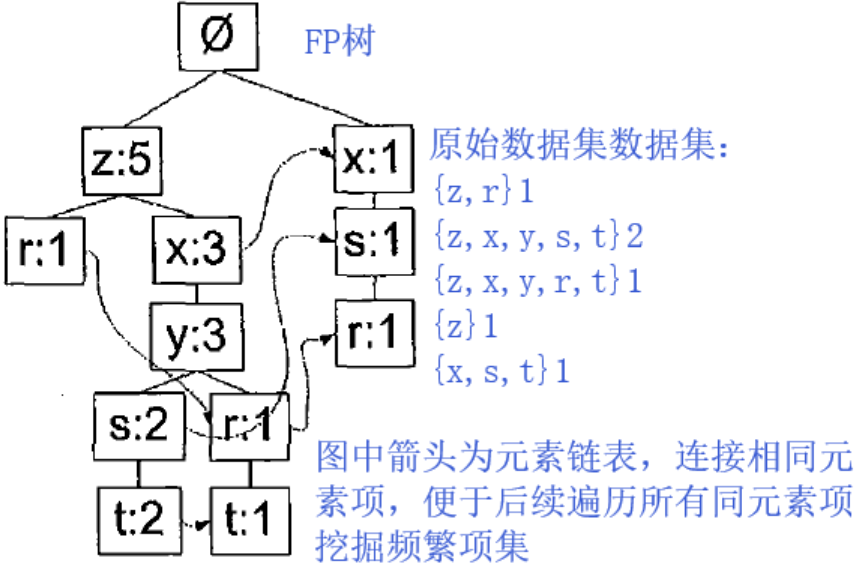

### FP-Growth v.s. Apriori
- FP-Growth：高效，只需要扫描两次数据集，第一次扫描计算各元素出现次数、第二次扫描构建FP树；频繁项集只需要从FP树挖掘即可
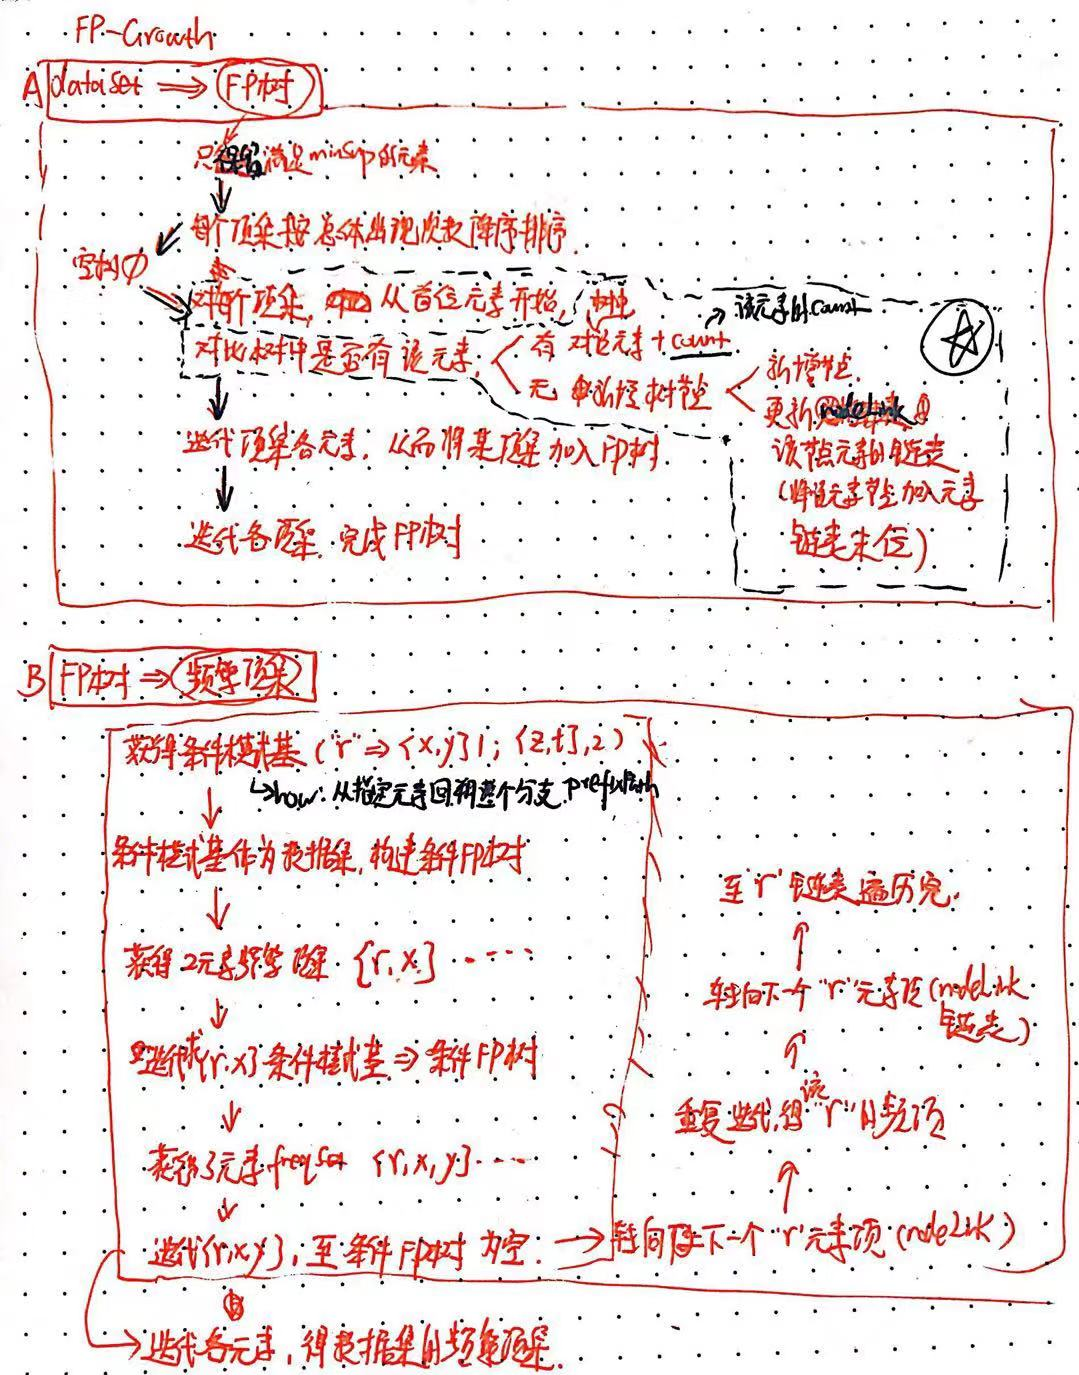

- Apriori：算法过程直观，除了挖掘频繁项集之外，还能够挖掘关联规则，但由于每次更新频繁项集都需要扫描一次整个数据集，效率不高
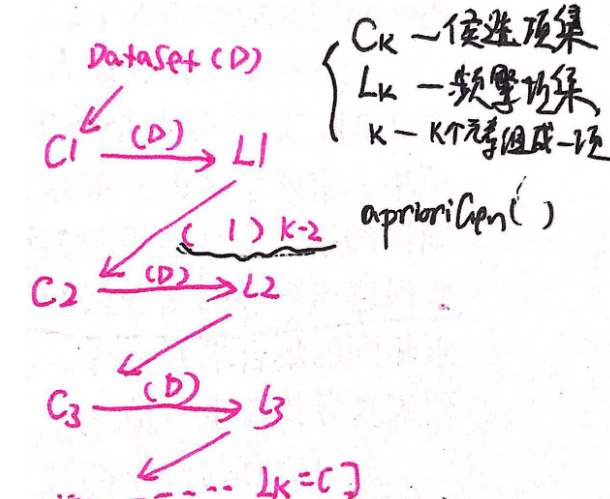

In [4]:
import numpy as np
import pandas as pd
import operator

In [5]:
# 树节点类
# 初始化节点名、节点元素出现次数、节点链表指针、父节点、子节点
# 计数函数
# 可视化树函数，便于调试

class treeNode:
    def __init__(self,nameValue,numOccur,parentNode):
        self.name=nameValue #节点名
        self.count=numOccur #节点元素出现次数
        self.nodeLink=None #存放节点链表中，与该节点相连的下一个元素
        self.parent=parentNode
        self.children={} #用于存放节点的子节点,value为子节点名
    
    def inc(self,numOccur):
        self.count+=numOccur
    
    def disp(self,ind=1):
        print("   "*ind,self.name,self.count) #输出一行节点名和节点元素数，缩进表示该行节点所处树的深度
        for child in self.children.values():
            child.disp(ind+1) #对于子节点，深度+1

### 1. 构建FP树

In [6]:
# 构造FP树
# dataSet为字典类型，表示探索频繁项集的数据集,keys为各项集，values为各项集在数据集中出现的次数
# minSup为最小支持度，构造FP树的第一步是计算数据集各元素的支持度，选择满足最小支持度的元素进入下一步
def createTree(dataSet,minSup=1):
    headerTable={}

    #遍历各项集,统计数据集中各元素的出现次数
    for key in dataSet.keys():
        for item in key:
            headerTable[item]=headerTable.get(item,0)+dataSet[key] 
            
    #遍历各元素，删除不满足最小支持度的元素
    for key in list(headerTable.keys()):
        if headerTable[key]<minSup:
            del headerTable[key]
    freqItemSet=set(headerTable.keys())
    
    #若没有元素满足最小支持度要求，返回None，结束函数
    if len(freqItemSet)==0:
        return None,None
    for key in headerTable.keys():
        headerTable[key]=[headerTable[key],None] #[元素出现次数，**指向每种项集第一个元素项的指针**]
    retTree=treeNode("Null Set",1,None) #初始化FP树的顶端节点
    
    for tranSet,count in dataSet.items():
        localD={} #存放每次循环中的频繁元素及其出现次数，便于利用全局出现次数对各项集元素进行项集内排序
        for item in tranSet:
            if item in freqItemSet:
                localD[item]=headerTable[item][0]
        if len(localD)>0:
            orderedItems=[v[0] for v in sorted(localD.items(),key=operator.itemgetter(1),reverse=True)] #根据元素全局出现次数对每个项集(tranSet)中的元素进行排序
            updateTree(orderedItems,retTree,headerTable,count) #使用排序后的项集对树进行填充
    return retTree,headerTable


#树的更新函数
#items为按出现次数排序后的项集，是待更新到树中的项集；count为items项集在数据集中的出现次数
#inTree为待被更新的树；headTable为头指针表，存放满足最小支持度要求的所有元素
def updateTree(items,inTree,headerTable,count):
    #若项集items当前最频繁的元素在已有树的子节点中，则直接增加树子节点的计数值，增加值为items[0]的出现次数
    if items[0] in inTree.children: 
        inTree.children[items[0]].inc(count)
    else:#若项集items当前最频繁的元素不在已有树的子节点中（即，树分支不存在），则通过treeNode类新增一个子节点
        inTree.children[items[0]]=treeNode(items[0],count,inTree)
        #若新增节点后表头表中没有此元素，则将该新增节点作为表头元素加入表头表
        if headerTable[items[0]][1]==None: 
            headerTable[items[0]][1]=inTree.children[items[0]]
        else:#若新增节点后表头表中有此元素，则更新该元素的链表，即，在该元素链表末尾增加该元素
            updateHeader(headerTable[items[0]][1],inTree.children[items[0]])
    #对于项集items元素个数多于1的情况，对剩下的元素迭代updateTree
    if len(items)>1:
        updateTree(items[1::],inTree.children[items[0]],headerTable,count)


#元素链表更新函数
#nodeToTest为待被更新的元素链表的头部
#targetNode为待加入到元素链表的元素节点
def updateHeader(nodeToTest,targetNode):
    #若待被更新的元素链表当前元素的下一个元素不为空，则一直迭代寻找该元素链表的末位元素
    while nodeToTest.nodeLink!=None: 
        nodeToTest=nodeToTest.nodeLink #类似撸绳子，从首位一个一个逐渐撸到末位
    #找到该元素链表的末尾元素后，在此元素后追加targetNode为该元素链表的新末尾元素
    nodeToTest.nodeLink=targetNode

#### 测试：FP树构建

In [10]:
#加载简单数据集
def loadSimpDat():
    simpDat = [['r', 'z', 'h', 'j', 'p'],
               ['z', 'y', 'x', 'w', 'v', 'u', 't', 's'],
               ['z'],
               ['r', 'x', 'n', 'o', 's'],
               ['y', 'r', 'x', 'z', 'q', 't', 'p'],
               ['y', 'z', 'x', 'e', 'q', 's', 't', 'm']]
    return simpDat

#将列表格式的数据集转化为字典格式
def createInitSet(dataSet):
    retDict={}
    for trans in dataSet:
        retDict[frozenset(trans)]=1
    return retDict

In [14]:
simpDat=loadSimpDat()
dataSet=createInitSet(simpDat)
dataSet

{frozenset({'z'}): 1,
 frozenset({'h', 'j', 'p', 'r', 'z'}): 1,
 frozenset({'s', 't', 'u', 'v', 'w', 'x', 'y', 'z'}): 1,
 frozenset({'n', 'o', 'r', 's', 'x'}): 1,
 frozenset({'p', 'q', 'r', 't', 'x', 'y', 'z'}): 1,
 frozenset({'e', 'm', 'q', 's', 't', 'x', 'y', 'z'}): 1}

In [15]:
myFPtree1,myHeaderTab1=createTree(dataSet,minSup=3)
myFPtree1.disp(),myHeaderTab1

    Null Set 1
       z 5
          r 1
          x 3
             y 3
                s 2
                   t 2
                r 1
                   t 1
       x 1
          r 1
             s 1


(None,
 {'r': [3, <__main__.treeNode at 0x2bd0a8d3630>],
  's': [3, <__main__.treeNode at 0x2bd0a8d3470>],
  't': [3, <__main__.treeNode at 0x2bd0a8d3940>],
  'x': [4, <__main__.treeNode at 0x2bd0a8d38d0>],
  'y': [3, <__main__.treeNode at 0x2bd0a8d3588>],
  'z': [5, <__main__.treeNode at 0x2bd0a8d3390>]})

### 2. 从FP树中挖掘频繁项集
1. **从FP树中获得条件模式基**
    - 条件模式基：以所查找元素项为结尾的路径集合，每条路径都是一条前缀路径，路径集合包括前缀路径和路径计数值。
        - 例如，元素"r"的条件模式基为 {x,s}2,{z,x,y}1,{z}1
    - 前缀路径：介于所查找元素和树根节点之间的所有内容
    - 路径计数值：等于该条前缀路径的起始元素项（即所查找的元素）的计数值
2. **利用条件模式基构建相应元素的条件FP树**
    - 对每个频繁项，都要创建一棵条件FP树。
    - 例如对元素t创建条件FP树：使用获得的t元素的条件模式基作为输入，利用构建FP树相同的逻辑构建元素t的条件FP树
3. **迭代步骤(1)(2)，直到树包含一个元素项为止**
    - 接下来继续构建{t,x}{t,y}{t,z}对应的条件FP树(tx,ty,tz为t条件FP树的频繁项集)，直到条件FP树中没有元素为止
    - 至此可以得到与元素t相关的频繁项集，包括2元素项集、3元素项集。。。。。。

#### 1. 从FP树中获得条件模式基

In [7]:
#由叶节点回溯该叶节点所在的整条路径
#leafNode为叶节点，treeNode格式；prefixPath为该叶节点的前缀路径集合，列表格式，在调用该函数前注意prefixPath的已有内容
def ascendTree(leafNode,prefixPath):
    if leafNode.parent!=None:
        prefixPath.append(leafNode.name)
        ascendTree(leafNode.parent,prefixPath)
        
#获得指定元素的条件模式基
#basePat为指定元素；treeNode为指定元素链表的第一个元素节点，如指定"r"元素，则treeNode为r元素链表的第一个r节点
def findPrefixPath(basePat,treeNode):
    condPats={} #存放指定元素的条件模式基
    while treeNode!=None: #当元素链表指向的节点不为空时（即，尚未遍历完指定元素的链表时）
        prefixPath=[]
        ascendTree(treeNode,prefixPath) #回溯该元素当前节点的前缀路径
        if len(prefixPath)>1:
            condPats[frozenset(prefixPath[1:])]=treeNode.count #构造该元素当前节点的条件模式基
        treeNode=treeNode.nodeLink #指向该元素链表的下一个元素
    return condPats

In [19]:
findPrefixPath('r',myHeaderTab1['r'][1])
findPrefixPath('t',myHeaderTab1['t'][1])

{frozenset({'s', 'x', 'y', 'z'}): 2, frozenset({'r', 'x', 'y', 'z'}): 1}

#### 2. 利用条件模式基构建相应元素的条件FP树，并迭代步骤(1)(2)，直到树包含一个元素项为止

In [41]:
#测试，利用createTree构建t元素的条件FP树
condTree1,condHeader1=createTree(findPrefixPath('t',myHeaderTab1['t'][1]),minSup=3)
condTree1.disp(),condHeader1

    Null Set 1
       z 3
          y 2
             x 2
          x 1
             y 1


(None,
 {'x': [3, <__main__.treeNode at 0x2bd0a8c2780>],
  'y': [3, <__main__.treeNode at 0x2bd0a8c28d0>],
  'z': [3, <__main__.treeNode at 0x2bd0a8c2630>]})

In [8]:
#有FP树挖掘频繁项集
#inTree: 构建好的整个数据集的FP树
#headerTable: FP树的头指针表
#minSup: 最小支持度，用于构建条件FP树
#preFix: 新增频繁项集的缓存表，set([])格式
#freqItemList: 频繁项集集合，list格式

def mineTree(inTree,headerTable,minSup,preFix,freqItemList):
    #按头指针表中元素出现次数升序排序，即，从头指针表底端开始寻找频繁项集
    bigL=[v[0] for v in sorted(headerTable.items(),key=lambda p:p[1][0])] 
    for basePat in bigL:
        #将当前深度的频繁项追加到已有频繁项集中，然后将此频繁项集追加到频繁项集列表中
        newFreqSet=preFix.copy()
        newFreqSet.add(basePat)
        print("freqItemList add newFreqSet",newFreqSet)
        freqItemList.append(newFreqSet)
        #获取当前频繁项的条件模式基
        condPatBases=findPrefixPath(basePat,headerTable[basePat][1])
        #利用当前频繁项的条件模式基构建条件FP树
        myCondTree,myHead=createTree(condPatBases,minSup)
        #迭代，直到当前频繁项的条件FP树为空
        if myHead!=None:
            mineTree(myCondTree,myHead,minSup,newFreqSet,freqItemList)

**测试：从FP树挖掘频繁项集**

In [47]:
freqItems=[]
mineTree(myFPtree1,myHeaderTab1,3,set([]),freqItems)
freqItems

freqItemList add newFreqSet {'r'}
freqItemList add newFreqSet {'y'}
freqItemList add newFreqSet {'z', 'y'}
freqItemList add newFreqSet {'y', 'x'}
freqItemList add newFreqSet {'z', 'y', 'x'}
freqItemList add newFreqSet {'s'}
freqItemList add newFreqSet {'x', 's'}
freqItemList add newFreqSet {'t'}
freqItemList add newFreqSet {'z', 't'}
freqItemList add newFreqSet {'y', 't'}
freqItemList add newFreqSet {'z', 'y', 't'}
freqItemList add newFreqSet {'x', 't'}
freqItemList add newFreqSet {'z', 'x', 't'}
freqItemList add newFreqSet {'x'}
freqItemList add newFreqSet {'z', 'x'}
freqItemList add newFreqSet {'z'}


[{'r'},
 {'y'},
 {'y', 'z'},
 {'x', 'y'},
 {'x', 'y', 'z'},
 {'s'},
 {'s', 'x'},
 {'t'},
 {'t', 'z'},
 {'t', 'y'},
 {'t', 'y', 'z'},
 {'t', 'x'},
 {'t', 'x', 'z'},
 {'x'},
 {'x', 'z'},
 {'z'}]

### 练习：挖掘新闻网站点击流
- 数据集kosarak.dat每个元素表示每个用户浏览过的新闻报道
- 我们要挖掘哪些新闻常常被同时浏览

In [2]:
parseDat=[line.split() for line in open(r'D:\DM\机器学习\机器学习实战\machinelearninginaction\Ch12\kosarak.dat').readlines()]
print(parseDat[:10],len(parseDat))

[['1', '2', '3'], ['1'], ['4', '5', '6', '7'], ['1', '8'], ['9', '10'], ['11', '6', '12', '13', '14', '15', '16'], ['1', '3', '7'], ['17', '18'], ['11', '6', '19', '20', '21', '22', '23', '24'], ['1', '25', '3']] 990002


In [13]:
initSet=createInitSet(parseDat)
newsFPtree1,newsHeaderTab1=createTree(initSet,100000)
newsFreqList=[]
mineTree(newsFPtree1,newsHeaderTab1,100000,set([]),newsFreqList)
newsFreqList

freqItemList add newFreqSet {'1'}
freqItemList add newFreqSet {'1', '6'}
freqItemList add newFreqSet {'3'}
freqItemList add newFreqSet {'3', '11'}
freqItemList add newFreqSet {'3', '6', '11'}
freqItemList add newFreqSet {'3', '6'}
freqItemList add newFreqSet {'11'}
freqItemList add newFreqSet {'6', '11'}
freqItemList add newFreqSet {'6'}


[{'1'},
 {'1', '6'},
 {'3'},
 {'11', '3'},
 {'11', '3', '6'},
 {'3', '6'},
 {'11'},
 {'11', '6'},
 {'6'}]

- 99万个用户的点击数据，其中支持度大于10万的频繁项集如上所示，表示有超过10万个用户同时点击了频繁项集中的各元素项集